<a href="https://colab.research.google.com/github/vladislavdarii/Ship-classification-using-Machine-Learning-techniques/blob/main/02_Decision_Tree_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#@title 1.0 Imports and drive mount

import numpy as np
from scipy.io import wavfile
import matplotlib.pyplot as plt
import os
import librosa
import scipy.signal
import pandas as pd
from numpy.matrixlib.defmatrix import matrix

#Writing and loading variables
import pickle

#Decission tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_validate
from sklearn.metrics import accuracy_score, confusion_matrix

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#@title 1.1 Function: Class Accuracy Plot and Metrics

def plot_class_acc(y_val, y_pred, strr):

  # Initialize the lists for correctly and incorrectly predicted values
  correct_preds = [0, 0, 0, 0]
  incorrect_preds = [0, 0, 0, 0]

  # Loop over the samples in y_test and y_pred
  for i in range(len(y_val)):
      if y_val[i] == y_pred[i]:
          correct_preds[y_val[i]] += 1
      else:
          incorrect_preds[y_val[i]] += 1

  # Set the colors for the bars
  bar_colors = ['#009965', '#a52a2b']

  # Create the bar chart with two parts for each bar
  fig, ax = plt.subplots(figsize=(8, 5))
  ax.bar(range(len(correct_preds)), correct_preds, color=bar_colors[0], label='Correct Predictions')
  ax.bar(range(len(incorrect_preds)), incorrect_preds, bottom=correct_preds, color=bar_colors[1], label='Incorrect Predictions')

  for i, (corr, incorr) in enumerate(zip(correct_preds, incorrect_preds)):
      ax.text(i, corr/2, str(corr), ha='center', va='center', color='white', fontsize=10, fontweight='bold')
      ax.text(i, corr + incorr/2, str(incorr), ha='center', va='center', color='white', fontsize=10, fontweight='bold')

  # Set the x-ticks and labels
  ax.set_xticks(range(len(correct_preds)))
  ax.set_xticklabels(['Class A', 'Class B', 'Class C', 'Class D'])

  # Set the labels and title
  ax.set_xlabel('Boat Type')
  ax.set_ylabel('Count')
  ax.set_title(strr)

  # Add the legend
  ax.legend()

  # Show the plot
  plt.show()

  # #Metric calculation
  # Create confusion matrix
  cm = confusion_matrix(y_val, y_pred)

  # Convert the confusion matrix to a pandas DataFrame
  confusion_matrix_df = pd.DataFrame(cm, columns=['Class A', 'Class B', 'Class C', 'Class D'])

  # Calculate metrics
  metrics_df = calculate_metrics(confusion_matrix_df.values)

  # Print the results
  print("Confusion Matrix:")
  print(confusion_matrix_df)
  print("\nMetrics:")
  print(metrics_df)

  return metrics_df, confusion_matrix_df

def calculate_metrics(confusion_matrix):
    tp = np.diagonal(confusion_matrix)
    fp = confusion_matrix.sum(axis=0) - tp
    fn = confusion_matrix.sum(axis=1) - tp
    tn = confusion_matrix.sum() - (tp + fp + fn)

    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
    f1_score = 2 * (precision * recall) / (precision + recall)
    accuracy = np.trace(confusion_matrix) / confusion_matrix.sum()

    metrics_dict = {
        'Class': ['Class 0', 'Class 1', 'Class 2', 'Class 3'],
        'Precision': precision,
        'Recall': recall,
        'F1 Score': f1_score,
        'Accuracy': accuracy
    }
    #Get rid of NaN values
    metrics_dict = pd.DataFrame(metrics_dict)
    metrics_dict.fillna(0, inplace=True)
    return metrics_dict

#@title 5.1 Get final metrics

def metrics_avg_var(metrics):
 row = [0,1,2,3]
 Precision = []
 Recall = []
 F1_Score = []
 Accuracy = []
 Precision_var = []
 Recall_var = []
 F1_Score_var = []
 Accuracy_var = []

 for a in row:
  Precision.append(np.average([df.loc[a, 'Precision'] for df in metrics]))
  Recall.append(np.average([df.loc[a, 'Recall'] for df in metrics]))
  F1_Score.append(np.average([df.loc[a, 'F1 Score'] for df in metrics]))
  Accuracy.append(np.average([df.loc[a, 'Accuracy'] for df in metrics]))
  Precision_var.append(np.std([df.loc[a, 'Precision'] for df in metrics]))
  Recall_var.append(np.std([df.loc[a, 'Recall'] for df in metrics]))
  F1_Score_var.append(np.std([df.loc[a, 'F1 Score'] for df in metrics]))
  Accuracy_var.append(np.std([df.loc[a, 'Accuracy'] for df in metrics]))

 metrics_dict = {
        'Class': ['Class 0', 'Class 1', 'Class 2', 'Class 3'],
        'Precision': Precision,
        'P_std' : Precision_var,
        'Recall': Recall,
        'R_std' : Recall_var,
        'F1 Score': F1_Score,
        'F1_std': F1_Score_var,
        'Accuracy': Accuracy,
        'Acc_std': Accuracy_var
    }


 return pd.DataFrame(metrics_dict)

In [ ]:
#@title 2.1 Data Load

def dataload(datax):
  # Define the directory where the file is saved
  directory = "./drive/MyDrive/TFG/Data/"

  # Load the variables from the file
  with open(os.path.join(directory, datax), "rb") as f:
      X_train, X_test, X_val, y_train, y_test, y_val = pickle.load(f)

  y_train = np.array(y_train)
  y_val = np.array(y_val)
  y_test = np.array(y_test)
  return X_train, X_test, X_val, y_train, y_test, y_val

def save_model(model,modeltype,n):

  model_filename = "decision_tree_" + str(modeltype) +  "_" + str(n) + ".pkl"

  # Define the directory where you want to save the file
  directory = "./drive/MyDrive/TFG/Models/"  #change to /DTs to actually overwrite stored models
  if 1 == 1:
    # Save the variables to a file
    with open(os.path.join(directory, model_filename), "wb") as f:
        pickle.dump((model), f)
    return

In [ ]:
#@title 3.1 Feature extraction: PSD

def get_psd():

  psd_train = []
  psd_test = []
  psd_val = []

  # Calculate the zero-crossing rate for X_train
  for audio in X_train:
    (f, S)= scipy.signal.welch(audio, 5000, nperseg=2*1024) # best so far 2*1024
    psd_train.append(S/max(S))

  psd_train = np.array(psd_train)

  # Calculate the zero-crossing rate for X_val
  for audio in X_val:
    (f, S)= scipy.signal.welch(audio, 5000, nperseg=2*1024)
    psd_val.append(S/max(S))

  psd_val = np.array(psd_val)

  # Calculate the zero-crossing rate for X_test
  for audio in X_test:
    (f, S)= scipy.signal.welch(audio, 5000, nperseg=2*1024)
    psd_test.append(S/max(S))

  psd_test = np.array(psd_test)
  return psd_train, psd_val, psd_test

In [ ]:
#@title 3.2 Feature extraction: MFCC
def get_mfcc():
# Define the frame length and hop length in samples
  frame_length = 2000
  hop_length =  1000

  # Define the number of MFCCs to extract
  num_mfcc = 15

  # Define the sampling rate of the audio signals
  sr = 52734

  mfcc_train = []
  mfcc_val = []
  mfcc_test = []

  # Extract MFCC features for the training set
  for audio in X_train:
      audio = np.asarray(audio, dtype=float)
      mfcc = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=num_mfcc,
                                  n_fft=frame_length, hop_length=hop_length)#, fmin = 25, fmax = 7500)
      mfcc_train.append(mfcc.flatten())

  # Convert the list of MFCCs to a NumPy array and squeeze the dimensions
  mfcc_train = np.array(mfcc_train)


  # Extract MFCC features for the validation set
  for audio in X_val:
      audio = np.asarray(audio, dtype=float)
      mfcc = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=num_mfcc,
                                  n_fft=frame_length, hop_length=hop_length)#, fmin = 25, fmax = 7500)
      mfcc_val.append(mfcc.flatten())


  # Convert the list of MFCCs to a NumPy array and squeeze the dimensions
  mfcc_val = np.array(mfcc_val)

  # Extract MFCC features for the test set
  for audio in X_test:
      audio = np.asarray(audio, dtype=float)
      mfcc = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=num_mfcc,
                                  n_fft=frame_length, hop_length=hop_length )#,fmin = 25, fmax = 7500)
      mfcc_test.append(mfcc.flatten())

  # Convert the list of MFCCs to a NumPy array and squeeze the dimensions
  mfcc_test = np.array(mfcc_test)
  return  mfcc_train, mfcc_val, mfcc_test

Fitting 5 folds for each of 100 candidates, totalling 500 fits


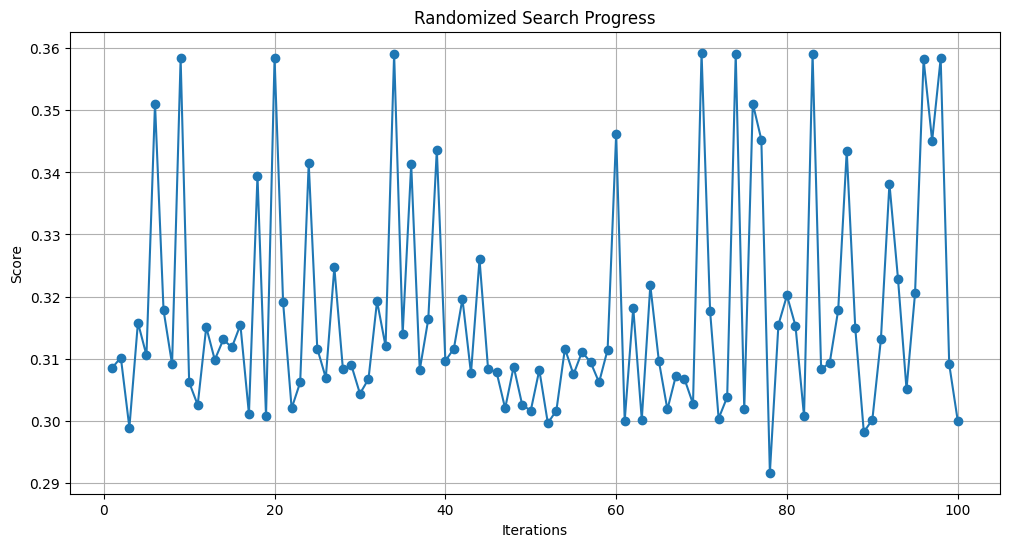

In [ ]:
#@title Decision Tree auto trainer
from sklearn.model_selection import RandomizedSearchCV


### RAW DATA

# Define the parameter grid for Decision Tree
param_dist = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [None] + list(np.arange(5, 31, 5)),
    'min_samples_split': np.arange(2, 11),
    'min_samples_leaf': np.arange(1, 11)
}

# Create a Decision Tree model
dt_model = DecisionTreeClassifier()

# Initialize RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=dt_model,
    param_distributions=param_dist,
    n_iter=100,  # Number of parameter settings that are sampled
    scoring='accuracy',  # Use a suitable scoring metric
    cv=5,  # Number of cross-validation folds
    verbose=2,
    n_jobs=-1,  # Number of jobs to run in parallel (-1 uses all available cores)
    random_state=42
)

X_train, X_test, X_val, y_train, y_test, y_val = dataload('data1.pkl')
psd_train, psd_val, psd_test = get_psd()
# Perform the randomized search
random_search.fit(X_train, y_train)

# Plotting the progress
results = random_search.cv_results_
plt.figure(figsize=(12, 6))
plt.title("Randomized Search Progress")
plt.xlabel("Iterations")
plt.ylabel("Score")
plt.grid(True)

# Plot the scores for each iteration
plt.plot(range(1, len(results['mean_test_score']) + 1), results['mean_test_score'], marker='o')

plt.show()

In [ ]:
# Print the best parameters and score
print("Best Parameters for DT RAW:", random_search.best_params_)
print("Best Score for DT RAW:", random_search.best_score_)

Best Parameters for DT RAW: {'min_samples_split': 8, 'min_samples_leaf': 9, 'max_depth': 5, 'criterion': 'entropy'}
Best Score for DT RAW: 0.3592857970055422


In [ ]:
######################################################################### RAW DATA

# Create a Random Forest model
dt_model_mfcc = DecisionTreeClassifier()

# Initialize RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=dt_model_mfcc,
    param_distributions=param_dist,
    n_iter=100,  # Number of parameter settings that are sampled
    scoring='accuracy',  # Use a suitable scoring metric
    cv=5,  # Number of cross-validation folds
    verbose=2,
    n_jobs=-1,
    random_state=42
)
mfcc_train, mfcc_val, mfcc_test = get_mfcc()
# Perform the randomized search
random_search.fit(mfcc_train, y_train)

# Print the best parameters and score
print("Best Parameters for MFCC:", random_search.best_params_)
print("Best Score for MFCC:", random_search.best_score_)

############################################################################ MFCC

# Create a Random Forest model
dt_model_psd = DecisionTreeClassifier()

# Initialize RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=dt_model_psd,
    param_distributions=param_dist,
    n_iter=100,  # Number of parameter settings that are sampled
    scoring='accuracy',  # Use a suitable scoring metric
    cv=5,  # Number of cross-validation folds
    verbose=2,
    n_jobs=-1,  # Number of jobs to run in parallel (-1 uses all available cores)
    random_state=42
)


psd_train, _, _ = get_psd()
# Perform the randomized search
random_search.fit(psd_train, y_train)

# Print the best parameters and score
print("Best Parameters for PSD:", random_search.best_params_)
print("Best Score for PSD:", random_search.best_score_)

Fitting 5 folds for each of 100 candidates, totalling 500 fits
Best Parameters for MFCC: {'min_samples_split': 3, 'min_samples_leaf': 1, 'max_depth': None, 'criterion': 'entropy'}
Best Score for MFCC: 0.7909734469352304
Fitting 5 folds for each of 100 candidates, totalling 500 fits
Best Parameters for PSD: {'min_samples_split': 4, 'min_samples_leaf': 3, 'max_depth': None, 'criterion': 'entropy'}
Best Score for PSD: 0.7134825047563902


In [ ]:
#@title 4.1 Decission Tree model Raw
def get_DT_rawdata(n):
  # Create a decision tree classifier
  tree_RAW = DecisionTreeClassifier(min_samples_split = 8 ,min_samples_leaf = 9, max_depth = 5, criterion = 'entropy')

  # Fit the model
  tree_RAW.fit(X_train,y_train)

  # Evaluate the accuracy of the model
  y_pred = tree_RAW.predict(X_val)
  plot_class_acc(y_val, y_pred, "Validation data")

  #Evaluate overfitting by printing training data results
  y_pred = tree_RAW.predict(X_train)
  plot_class_acc(y_train, y_pred, "Train data")

  y_pred = tree_RAW.predict(X_test)
  metrics, matrix = plot_class_acc(y_test, y_pred, "Test Data")

  save_model(tree_RAW,"raw",n)
  return  metrics, matrix

In [ ]:
#@title 4.2 Decission Tree model MFCC

def get_DT_mfcc(n):
# Create a decision tree classifier
  tree_mfcc = DecisionTreeClassifier(min_samples_split = 3 ,min_samples_leaf = 1, max_depth = None, criterion = 'entropy')

  # Fit the model to the training data
  tree_mfcc.fit(mfcc_train, y_train)

  # Evaluate the accuracy of the model
  y_pred = tree_mfcc.predict(mfcc_val)
  x = plot_class_acc(y_val, y_pred, "Validation data")

  #Evaluate overfitting by printing training data results
  y_pred = tree_mfcc.predict(mfcc_train)
  x = plot_class_acc(y_train, y_pred, "Train data")

  #Evaluate overfitting by printing training data results
  y_pred = tree_mfcc.predict(mfcc_test)
  metrics, matrix = plot_class_acc(y_test, y_pred, "Test data")
  save_model(tree_mfcc,"mfcc",n)
  return metrics, matrix

In [ ]:
#@title 4.3 Decission Tree model PSD

def get_DT_psd(n):
  # Create a decision tree classifier
  tree_psd = DecisionTreeClassifier(min_samples_split = 4 ,min_samples_leaf = 3, max_depth = None, criterion = 'entropy')

  # Fit the model to the training data
  tree_psd.fit(psd_train, y_train)

  # Evaluate the accuracy of the model
  y_pred = tree_psd.predict(psd_val)

  x = plot_class_acc(y_val, y_pred, "Validation data")

  #Evaluate overfitting by printing training data results
  y_pred =tree_psd.predict(psd_train)
  x = plot_class_acc(y_train, y_pred, "Train data")

  #Evaluate overfitting by printing training data results
  y_pred = tree_psd.predict(psd_test)
  metrics, matrix = plot_class_acc(y_test, y_pred, "Test data")

  save_model(tree_psd,"psd",n)
  return  metrics, matrix

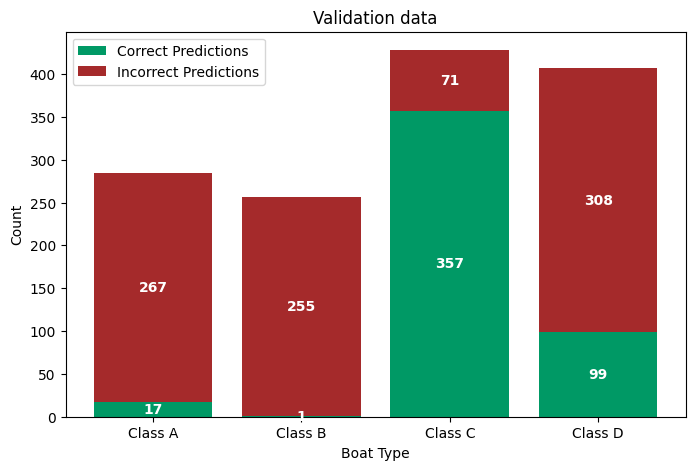

Confusion Matrix:
   Class A  Class B  Class C  Class D
0       17        2      206       59
1       11        1      219       25
2       13        4      357       54
3       25        2      281       99

Metrics:
     Class  Precision    Recall  F1 Score  Accuracy
0  Class 0   0.257576  0.059859  0.097143  0.344727
1  Class 1   0.111111  0.003906  0.007547  0.344727
2  Class 2   0.335842  0.834112  0.478873  0.344727
3  Class 3   0.417722  0.243243  0.307453  0.344727


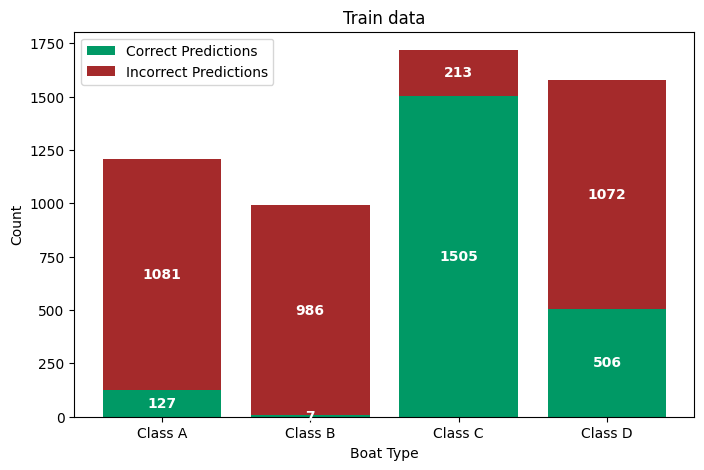

Confusion Matrix:
   Class A  Class B  Class C  Class D
0      127        6      890      185
1       20        7      895       71
2       57        0     1505      156
3       76        0      996      506

Metrics:
     Class  Precision    Recall  F1 Score  Accuracy
0  Class 0   0.453571  0.105132  0.170699  0.390213
1  Class 1   0.538462  0.007049  0.013917  0.390213
2  Class 2   0.351143  0.876019  0.501332  0.390213
3  Class 3   0.551198  0.320659  0.405449  0.390213


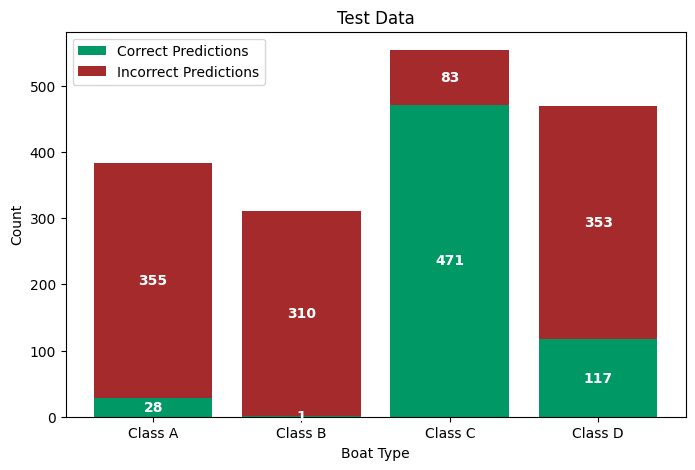

Confusion Matrix:
   Class A  Class B  Class C  Class D
0       28        1      287       67
1        9        1      270       31
2       23        1      471       59
3       32        1      320      117

Metrics:
     Class  Precision    Recall  F1 Score  Accuracy
0  Class 0   0.304348  0.073107  0.117895  0.359139
1  Class 1   0.250000  0.003215  0.006349  0.359139
2  Class 2   0.349407  0.850181  0.495268  0.359139
3  Class 3   0.427007  0.248936  0.314516  0.359139


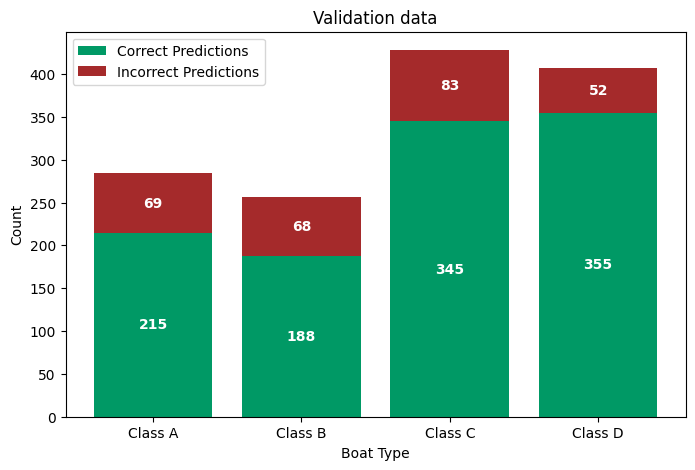

Confusion Matrix:
   Class A  Class B  Class C  Class D
0      215       23       25       21
1       20      188       41        7
2       30       35      345       18
3       29        8       15      355

Metrics:
     Class  Precision    Recall  F1 Score  Accuracy
0  Class 0   0.731293  0.757042  0.743945  0.802182
1  Class 1   0.740157  0.734375  0.737255  0.802182
2  Class 2   0.809859  0.806075  0.807963  0.802182
3  Class 3   0.885287  0.872236  0.878713  0.802182


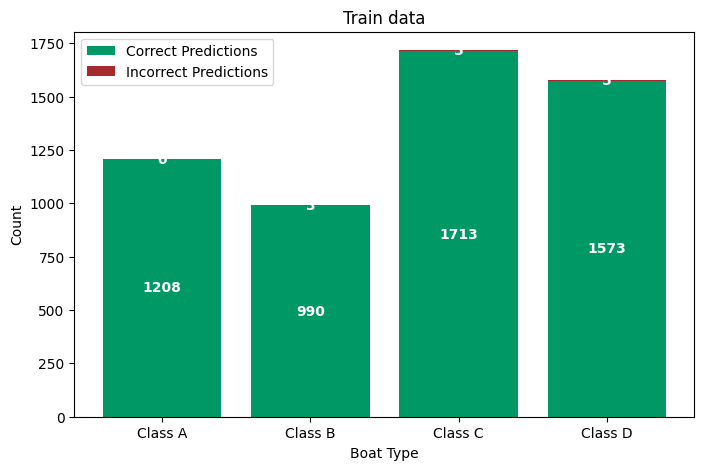

Confusion Matrix:
   Class A  Class B  Class C  Class D
0     1208        0        0        0
1        3      990        0        0
2        3        2     1713        0
3        2        2        1     1573

Metrics:
     Class  Precision    Recall  F1 Score  Accuracy
0  Class 0   0.993421  1.000000  0.996700  0.997635
1  Class 1   0.995976  0.996979  0.996477  0.997635
2  Class 2   0.999417  0.997090  0.998252  0.997635
3  Class 3   1.000000  0.996831  0.998413  0.997635


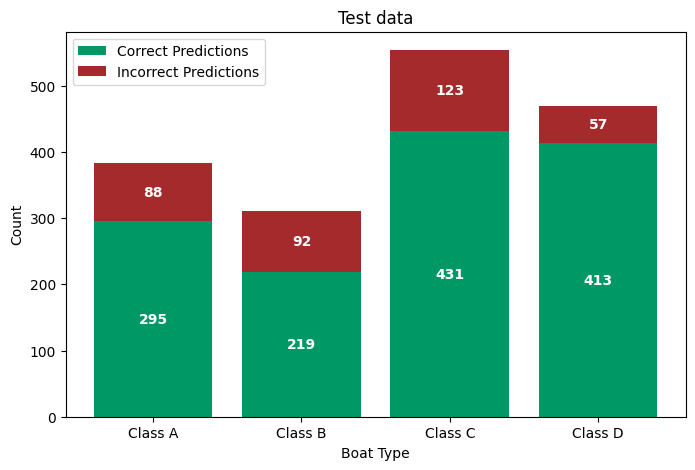

Confusion Matrix:
   Class A  Class B  Class C  Class D
0      295       26       33       29
1       29      219       54        9
2       54       45      431       24
3       25       10       22      413

Metrics:
     Class  Precision    Recall  F1 Score  Accuracy
0  Class 0   0.732010  0.770235  0.750636  0.790454
1  Class 1   0.730000  0.704180  0.716858  0.790454
2  Class 2   0.798148  0.777978  0.787934  0.790454
3  Class 3   0.869474  0.878723  0.874074  0.790454


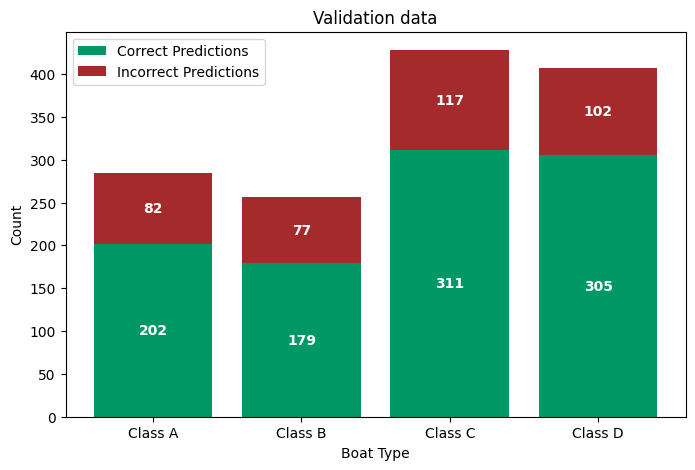

Confusion Matrix:
   Class A  Class B  Class C  Class D
0      202       13       51       18
1       25      179       34       18
2       47       38      311       32
3       43       22       37      305

Metrics:
     Class  Precision    Recall  F1 Score  Accuracy
0  Class 0   0.637224  0.711268  0.672213  0.725091
1  Class 1   0.710317  0.699219  0.704724  0.725091
2  Class 2   0.718245  0.726636  0.722416  0.725091
3  Class 3   0.817694  0.749386  0.782051  0.725091


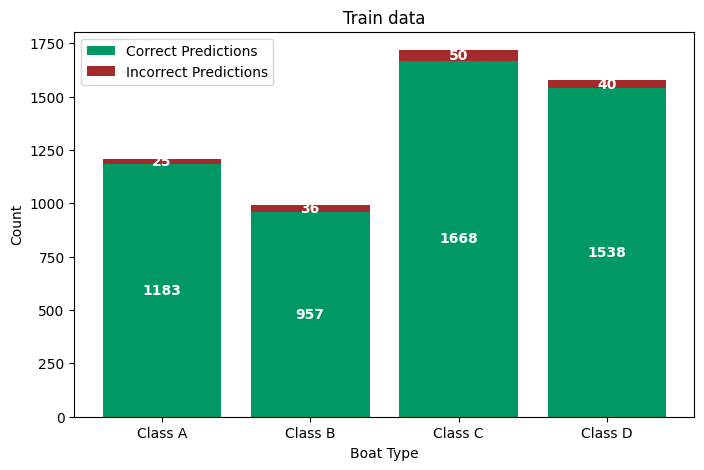

Confusion Matrix:
   Class A  Class B  Class C  Class D
0     1183        5       13        7
1       13      957       18        5
2       17       23     1668       10
3       17       11       12     1538

Metrics:
     Class  Precision    Recall  F1 Score  Accuracy
0  Class 0   0.961789  0.979305  0.970468   0.97253
1  Class 1   0.960843  0.963746  0.962293   0.97253
2  Class 2   0.974868  0.970896  0.972878   0.97253
3  Class 3   0.985897  0.974651  0.980242   0.97253


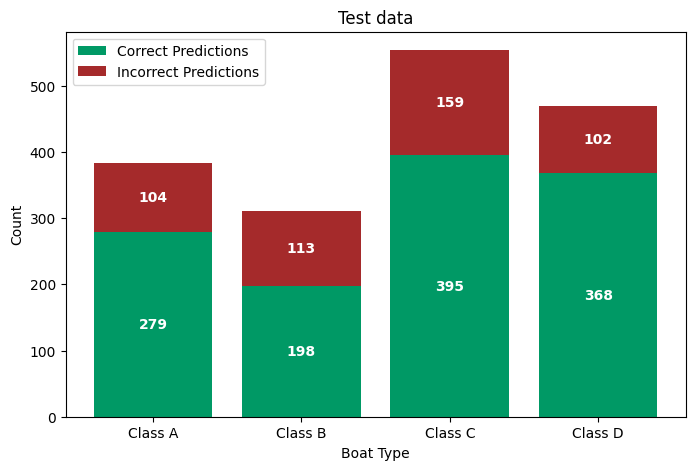

Confusion Matrix:
   Class A  Class B  Class C  Class D
0      279       21       60       23
1       32      198       62       19
2       54       67      395       38
3       32       18       52      368

Metrics:
     Class  Precision    Recall  F1 Score  Accuracy
0  Class 0   0.702771  0.728460  0.715385  0.721769
1  Class 1   0.651316  0.636656  0.643902  0.721769
2  Class 2   0.694200  0.712996  0.703473  0.721769
3  Class 3   0.821429  0.782979  0.801743  0.721769


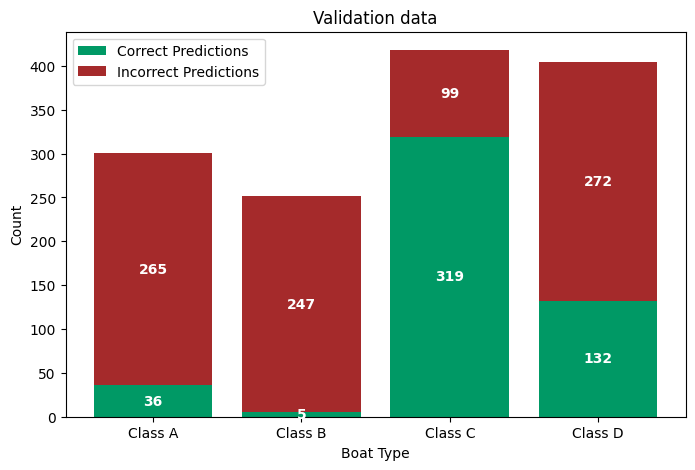

Confusion Matrix:
   Class A  Class B  Class C  Class D
0       36        6      166       93
1        3        5      197       47
2        6       15      319       78
3        7        6      259      132

Metrics:
     Class  Precision    Recall  F1 Score  Accuracy
0  Class 0   0.692308  0.119601  0.203966  0.357818
1  Class 1   0.156250  0.019841  0.035211  0.357818
2  Class 2   0.339001  0.763158  0.469463  0.357818
3  Class 3   0.377143  0.326733  0.350133  0.357818


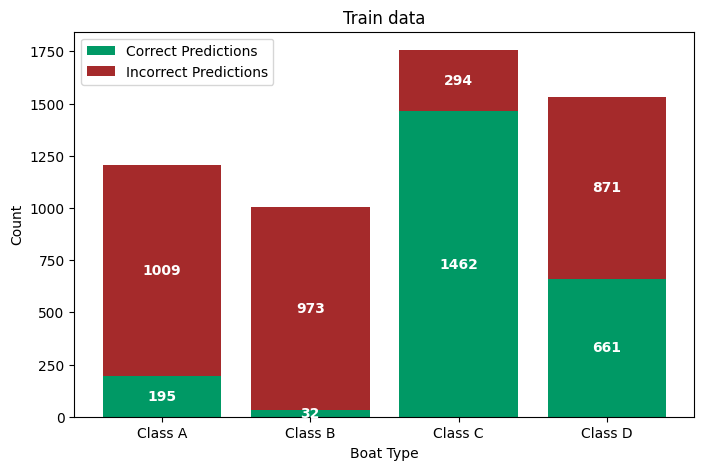

Confusion Matrix:
   Class A  Class B  Class C  Class D
0      195       25      664      320
1        2       32      835      136
2        3       24     1462      267
3       25       28      818      661

Metrics:
     Class  Precision    Recall  F1 Score  Accuracy
0  Class 0   0.866667  0.161960  0.272918  0.427506
1  Class 1   0.293578  0.031841  0.057451  0.427506
2  Class 2   0.386875  0.832574  0.528275  0.427506
3  Class 3   0.477601  0.431462  0.453361  0.427506


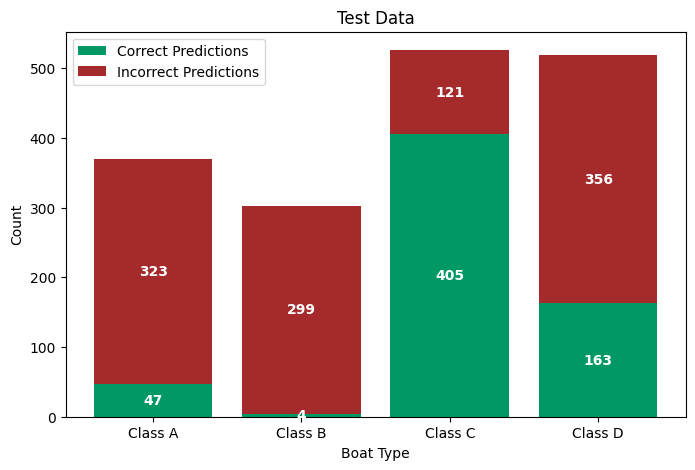

Confusion Matrix:
   Class A  Class B  Class C  Class D
0       47        8      207      108
1        3        4      242       54
2        9        9      405      103
3       17       10      329      163

Metrics:
     Class  Precision    Recall  F1 Score  Accuracy
0  Class 0   0.618421  0.127027  0.210762  0.360303
1  Class 1   0.129032  0.013201  0.023952  0.360303
2  Class 2   0.342350  0.769962  0.473961  0.360303
3  Class 3   0.380841  0.314066  0.344245  0.360303


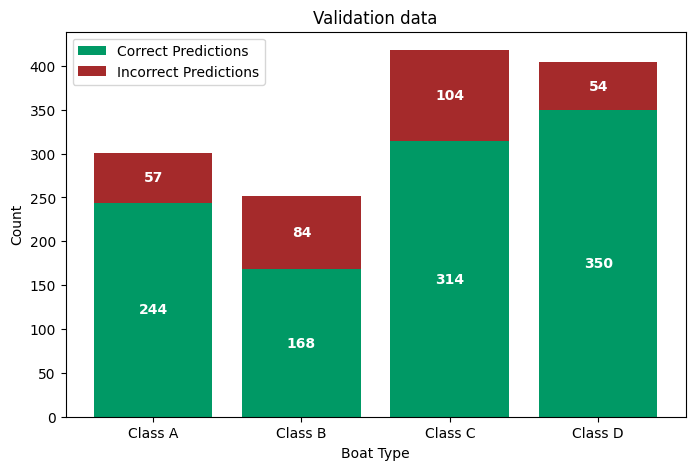

Confusion Matrix:
   Class A  Class B  Class C  Class D
0      244       15       27       15
1       27      168       46       11
2       33       38      314       33
3       26        5       23      350

Metrics:
     Class  Precision    Recall  F1 Score  Accuracy
0  Class 0   0.739394  0.810631  0.773376  0.782545
1  Class 1   0.743363  0.666667  0.702929  0.782545
2  Class 2   0.765854  0.751196  0.758454  0.782545
3  Class 3   0.855746  0.866337  0.861009  0.782545


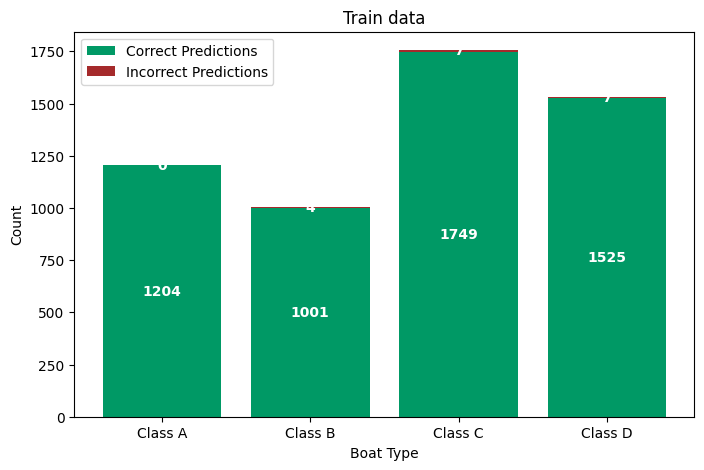

Confusion Matrix:
   Class A  Class B  Class C  Class D
0     1204        0        0        0
1        4     1001        0        0
2        4        3     1749        0
3        3        3        1     1525

Metrics:
     Class  Precision    Recall  F1 Score  Accuracy
0  Class 0   0.990947  1.000000  0.995453  0.996725
1  Class 1   0.994042  0.996020  0.995030  0.996725
2  Class 2   0.999429  0.996014  0.997718  0.996725
3  Class 3   1.000000  0.995431  0.997710  0.996725


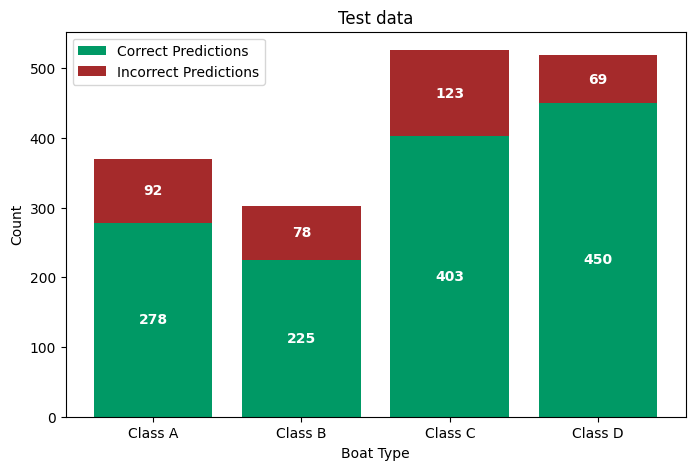

Confusion Matrix:
   Class A  Class B  Class C  Class D
0      278       33       34       25
1       27      225       40       11
2       37       51      403       35
3       40       11       18      450

Metrics:
     Class  Precision    Recall  F1 Score  Accuracy
0  Class 0   0.727749  0.751351  0.739362   0.78929
1  Class 1   0.703125  0.742574  0.722311   0.78929
2  Class 2   0.814141  0.766160  0.789422   0.78929
3  Class 3   0.863724  0.867052  0.865385   0.78929


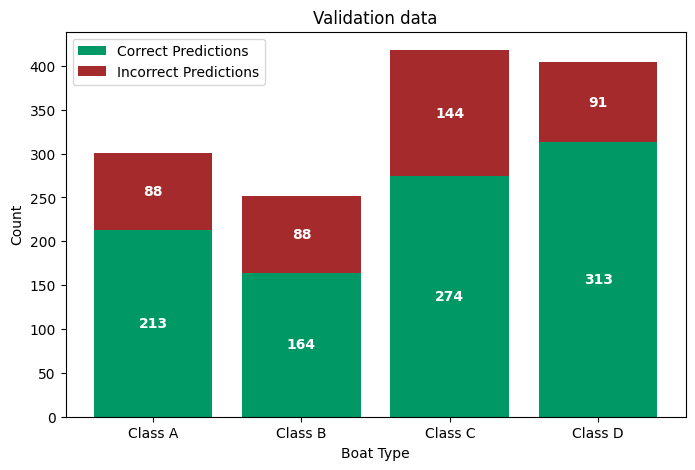

Confusion Matrix:
   Class A  Class B  Class C  Class D
0      213       26       41       21
1       33      164       42       13
2       67       52      274       25
3       24       26       41      313

Metrics:
     Class  Precision    Recall  F1 Score  Accuracy
0  Class 0   0.632047  0.707641  0.667712  0.701091
1  Class 1   0.611940  0.650794  0.630769  0.701091
2  Class 2   0.688442  0.655502  0.671569  0.701091
3  Class 3   0.841398  0.774752  0.806701  0.701091


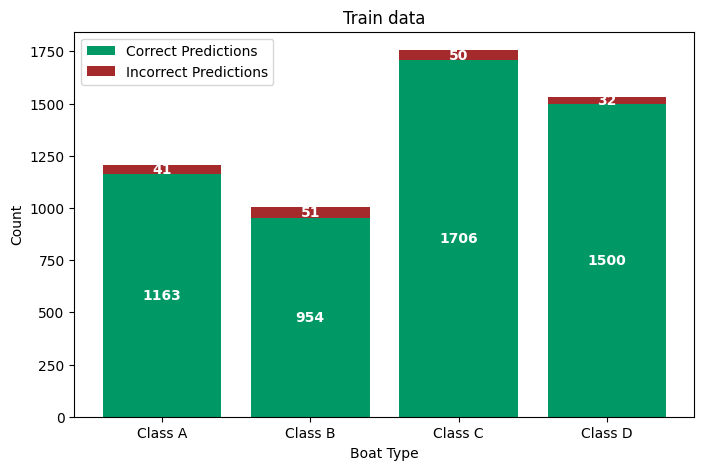

Confusion Matrix:
   Class A  Class B  Class C  Class D
0     1163        8       18       15
1       21      954       20       10
2       21       17     1706       12
3       12       10       10     1500

Metrics:
     Class  Precision    Recall  F1 Score  Accuracy
0  Class 0   0.955629  0.965947  0.960760  0.968346
1  Class 1   0.964611  0.949254  0.956871  0.968346
2  Class 2   0.972634  0.971526  0.972080  0.968346
3  Class 3   0.975927  0.979112  0.977517  0.968346


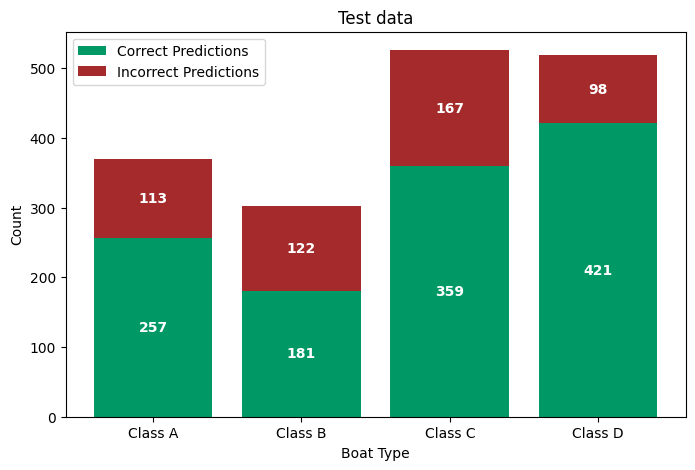

Confusion Matrix:
   Class A  Class B  Class C  Class D
0      257       32       44       37
1       44      181       51       27
2       57       67      359       43
3       33       25       40      421

Metrics:
     Class  Precision    Recall  F1 Score  Accuracy
0  Class 0   0.657289  0.694595  0.675427  0.708964
1  Class 1   0.593443  0.597360  0.595395  0.708964
2  Class 2   0.726721  0.682510  0.703922  0.708964
3  Class 3   0.797348  0.811175  0.804202  0.708964


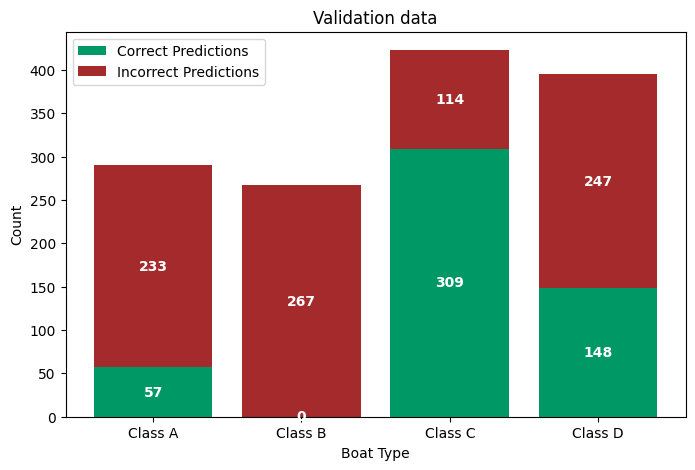

<ipython-input-4-77e221fb2a91>:67: RuntimeWarning: invalid value encountered in divide
  precision = tp / (tp + fp)


Confusion Matrix:
   Class A  Class B  Class C  Class D
0       57        0      146       87
1        2        0      212       53
2        8        0      309      106
3       25        0      222      148

Metrics:
     Class  Precision    Recall  F1 Score  Accuracy
0  Class 0   0.619565  0.196552  0.298429  0.373818
1  Class 1   0.000000  0.000000  0.000000  0.373818
2  Class 2   0.347582  0.730496  0.471037  0.373818
3  Class 3   0.375635  0.374684  0.375158  0.373818


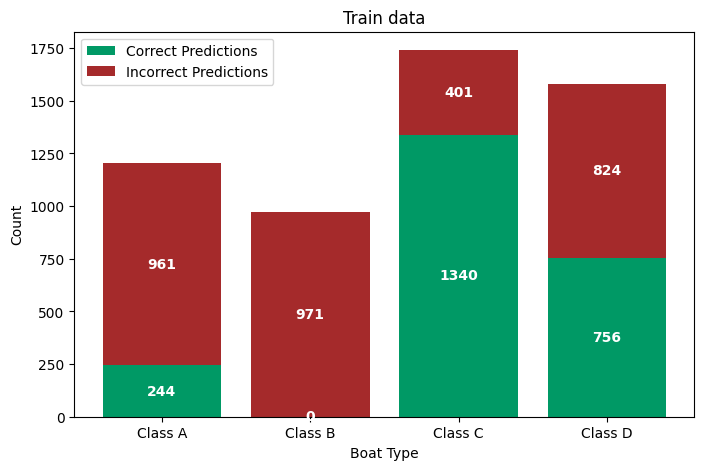

<ipython-input-4-77e221fb2a91>:67: RuntimeWarning: invalid value encountered in divide
  precision = tp / (tp + fp)


Confusion Matrix:
   Class A  Class B  Class C  Class D
0      244        0      627      334
1       25        0      773      173
2       16        0     1340      385
3       70        0      754      756

Metrics:
     Class  Precision    Recall  F1 Score  Accuracy
0  Class 0   0.687324  0.202490  0.312821  0.425687
1  Class 1   0.000000  0.000000  0.000000  0.425687
2  Class 2   0.383515  0.769673  0.511939  0.425687
3  Class 3   0.458738  0.478481  0.468401  0.425687


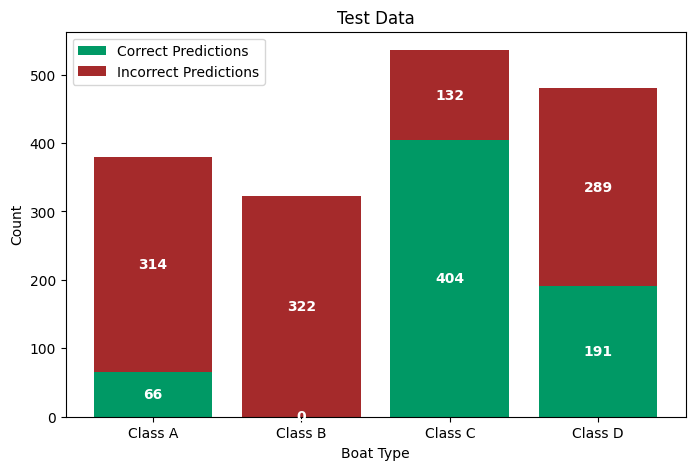

<ipython-input-4-77e221fb2a91>:67: RuntimeWarning: invalid value encountered in divide
  precision = tp / (tp + fp)


Confusion Matrix:
   Class A  Class B  Class C  Class D
0       66        0      194      120
1        6        0      242       74
2       21        0      404      111
3       17        0      272      191

Metrics:
     Class  Precision    Recall  F1 Score  Accuracy
0  Class 0   0.600000  0.173684  0.269388   0.38475
1  Class 1   0.000000  0.000000  0.000000   0.38475
2  Class 2   0.363309  0.753731  0.490291   0.38475
3  Class 3   0.385081  0.397917  0.391393   0.38475


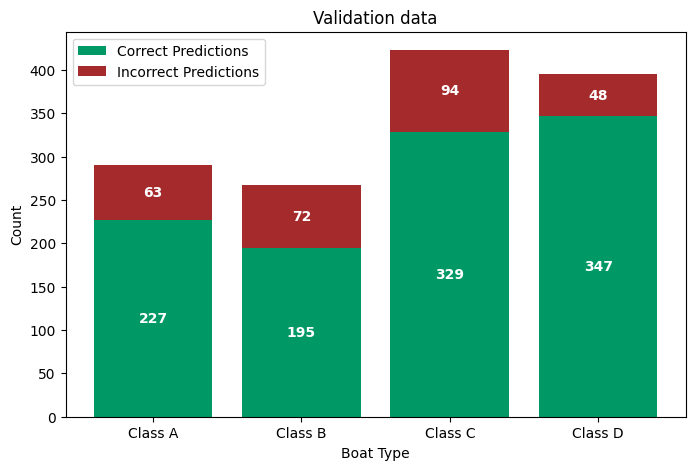

Confusion Matrix:
   Class A  Class B  Class C  Class D
0      227       17       17       29
1       19      195       43       10
2       33       40      329       21
3       19        4       25      347

Metrics:
     Class  Precision    Recall  F1 Score  Accuracy
0  Class 0   0.761745  0.782759  0.772109  0.798545
1  Class 1   0.761719  0.730337  0.745698  0.798545
2  Class 2   0.794686  0.777778  0.786141  0.798545
3  Class 3   0.852580  0.878481  0.865337  0.798545


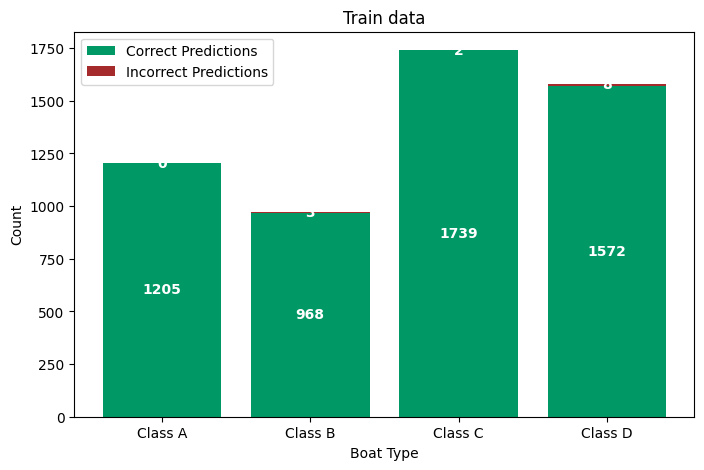

Confusion Matrix:
   Class A  Class B  Class C  Class D
0     1205        0        0        0
1        3      968        0        0
2        1        1     1739        0
3        3        1        4     1572

Metrics:
     Class  Precision    Recall  F1 Score  Accuracy
0  Class 0   0.994224  1.000000  0.997104  0.997635
1  Class 1   0.997938  0.996910  0.997424  0.997635
2  Class 2   0.997705  0.998851  0.998278  0.997635
3  Class 3   1.000000  0.994937  0.997462  0.997635


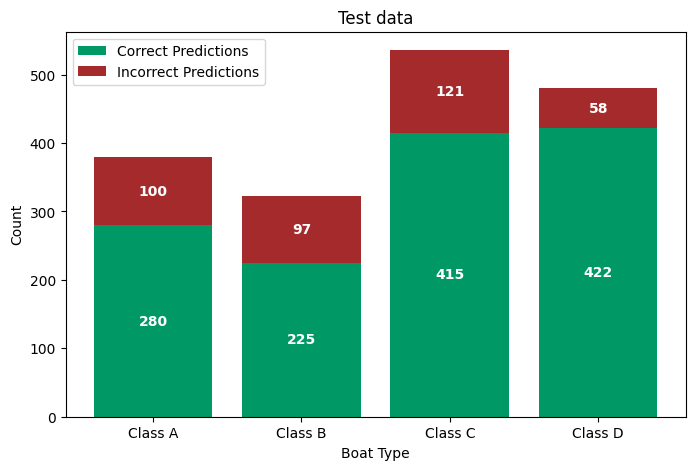

Confusion Matrix:
   Class A  Class B  Class C  Class D
0      280       28       42       30
1       30      225       53       14
2       36       61      415       24
3       24        8       26      422

Metrics:
     Class  Precision    Recall  F1 Score  Accuracy
0  Class 0   0.756757  0.736842  0.746667  0.781141
1  Class 1   0.698758  0.698758  0.698758  0.781141
2  Class 2   0.774254  0.774254  0.774254  0.781141
3  Class 3   0.861224  0.879167  0.870103  0.781141


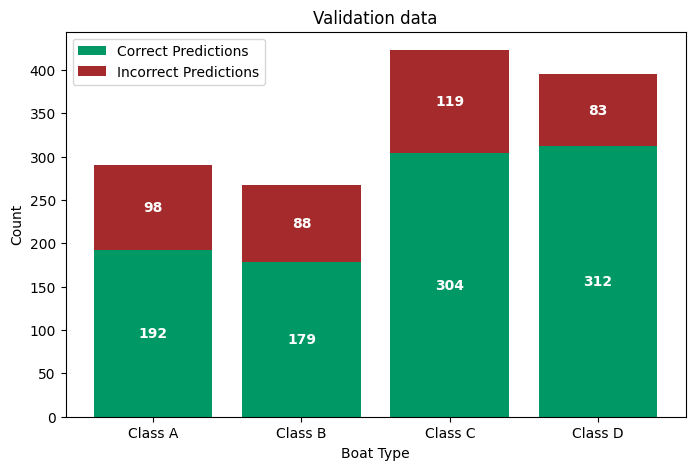

Confusion Matrix:
   Class A  Class B  Class C  Class D
0      192       31       39       28
1       21      179       51       16
2       35       54      304       30
3       30       15       38      312

Metrics:
     Class  Precision    Recall  F1 Score  Accuracy
0  Class 0   0.690647  0.662069  0.676056  0.717818
1  Class 1   0.641577  0.670412  0.655678  0.717818
2  Class 2   0.703704  0.718676  0.711111  0.717818
3  Class 3   0.808290  0.789873  0.798976  0.717818


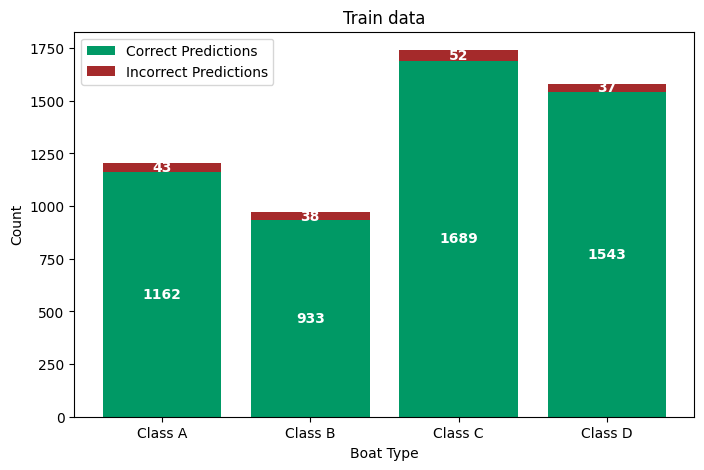

Confusion Matrix:
   Class A  Class B  Class C  Class D
0     1162        8       21       14
1       19      933       14        5
2       20       22     1689       10
3       14        8       15     1543

Metrics:
     Class  Precision    Recall  F1 Score  Accuracy
0  Class 0   0.956379  0.964315  0.960331  0.969074
1  Class 1   0.960865  0.960865  0.960865  0.969074
2  Class 2   0.971248  0.970132  0.970690  0.969074
3  Class 3   0.981552  0.976582  0.979061  0.969074


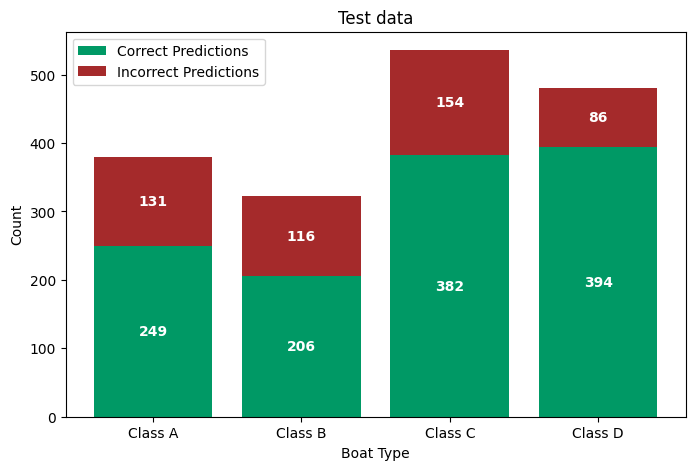

Confusion Matrix:
   Class A  Class B  Class C  Class D
0      249       35       61       35
1       33      206       64       19
2       46       61      382       47
3       28       21       37      394

Metrics:
     Class  Precision    Recall  F1 Score  Accuracy
0  Class 0   0.699438  0.655263  0.676630  0.716531
1  Class 1   0.637771  0.639752  0.638760  0.716531
2  Class 2   0.702206  0.712687  0.707407  0.716531
3  Class 3   0.795960  0.820833  0.808205  0.716531


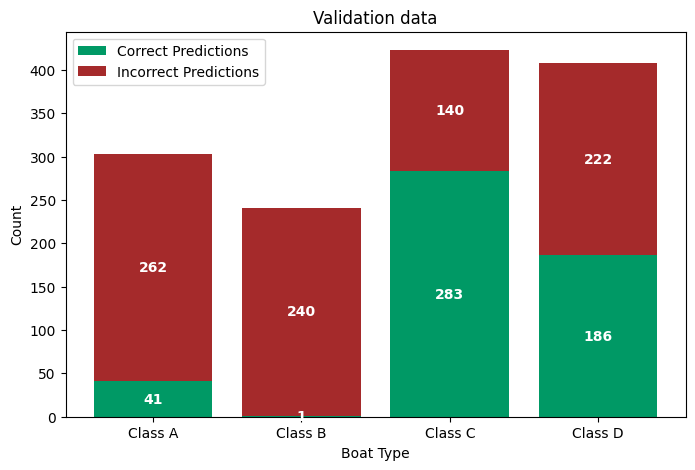

Confusion Matrix:
   Class A  Class B  Class C  Class D
0       41        2      138      122
1        1        1      170       69
2        9        0      283      131
3       17        3      202      186

Metrics:
     Class  Precision    Recall  F1 Score  Accuracy
0  Class 0   0.602941  0.135314  0.221024  0.371636
1  Class 1   0.166667  0.004149  0.008097  0.371636
2  Class 2   0.356873  0.669031  0.465461  0.371636
3  Class 3   0.366142  0.455882  0.406114  0.371636


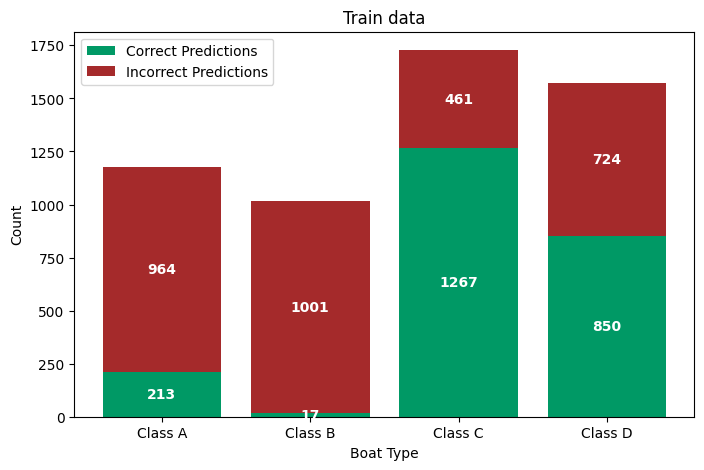

Confusion Matrix:
   Class A  Class B  Class C  Class D
0      213        3      580      381
1        7       17      714      280
2       13        2     1267      446
3       27        3      694      850

Metrics:
     Class  Precision    Recall  F1 Score  Accuracy
0  Class 0   0.819231  0.180969  0.296451   0.42696
1  Class 1   0.680000  0.016699  0.032598   0.42696
2  Class 2   0.389247  0.733218  0.508529   0.42696
3  Class 3   0.434338  0.540025  0.481450   0.42696


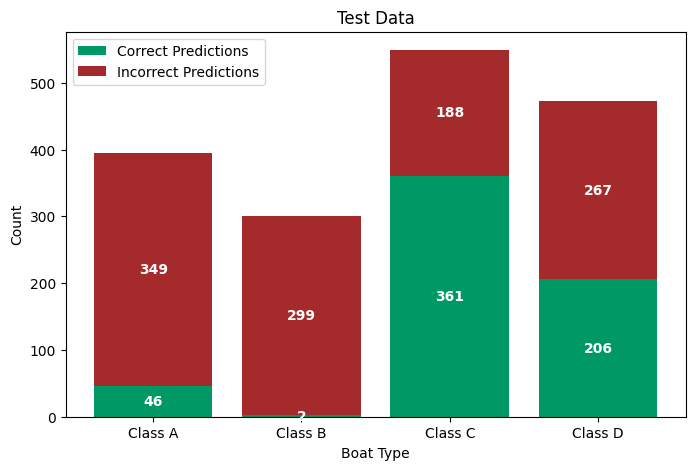

Confusion Matrix:
   Class A  Class B  Class C  Class D
0       46        1      197      151
1        1        2      184      114
2       12        2      361      174
3       17        0      250      206

Metrics:
     Class  Precision    Recall  F1 Score  Accuracy
0  Class 0   0.605263  0.116456  0.195329  0.357974
1  Class 1   0.400000  0.006645  0.013072  0.357974
2  Class 2   0.363911  0.657559  0.468527  0.357974
3  Class 3   0.319380  0.435518  0.368515  0.357974


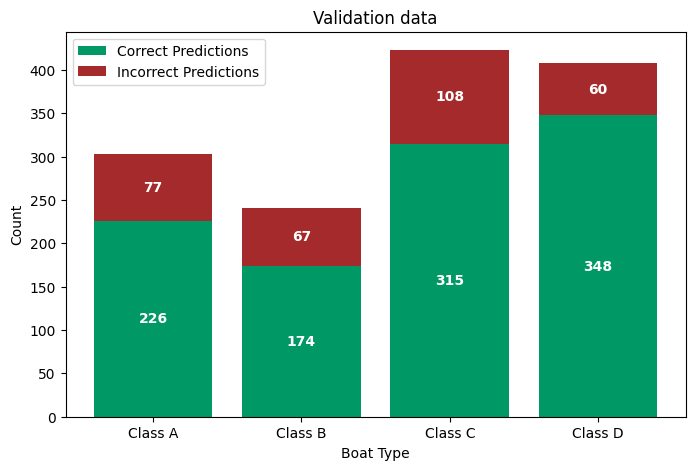

Confusion Matrix:
   Class A  Class B  Class C  Class D
0      226       27       26       24
1       19      174       36       12
2       40       44      315       24
3       29        7       24      348

Metrics:
     Class  Precision    Recall  F1 Score  Accuracy
0  Class 0   0.719745  0.745875  0.732577  0.773091
1  Class 1   0.690476  0.721992  0.705882  0.773091
2  Class 2   0.785536  0.744681  0.764563  0.773091
3  Class 3   0.852941  0.852941  0.852941  0.773091


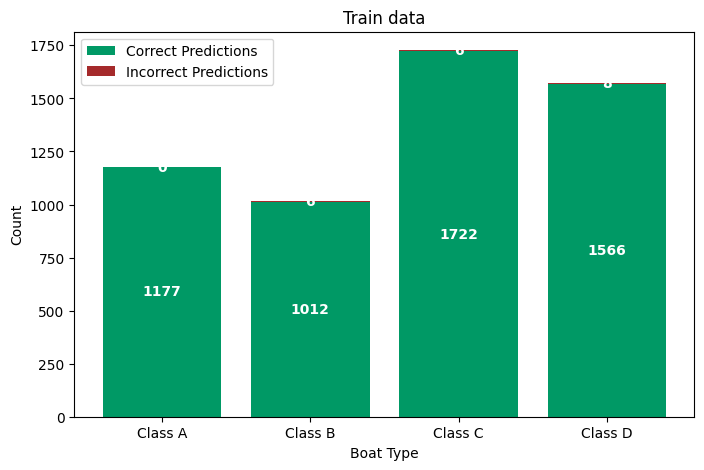

Confusion Matrix:
   Class A  Class B  Class C  Class D
0     1177        0        0        0
1        6     1012        0        0
2        4        2     1722        0
3        3        1        4     1566

Metrics:
     Class  Precision    Recall  F1 Score  Accuracy
0  Class 0   0.989076  1.000000  0.994508  0.996362
1  Class 1   0.997044  0.994106  0.995573  0.996362
2  Class 2   0.997683  0.996528  0.997105  0.996362
3  Class 3   1.000000  0.994917  0.997452  0.996362


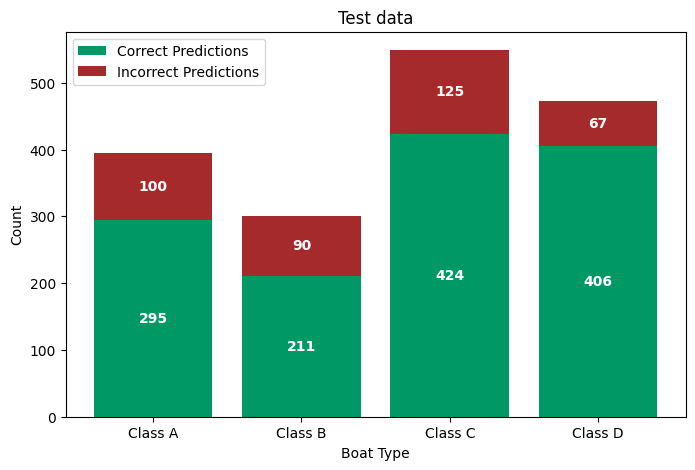

Confusion Matrix:
   Class A  Class B  Class C  Class D
0      295       22       40       38
1       26      211       55        9
2       43       45      424       37
3       36        9       22      406

Metrics:
     Class  Precision    Recall  F1 Score  Accuracy
0  Class 0   0.737500  0.746835  0.742138  0.777648
1  Class 1   0.735192  0.700997  0.717687  0.777648
2  Class 2   0.783734  0.772313  0.777982  0.777648
3  Class 3   0.828571  0.858351  0.843198  0.777648


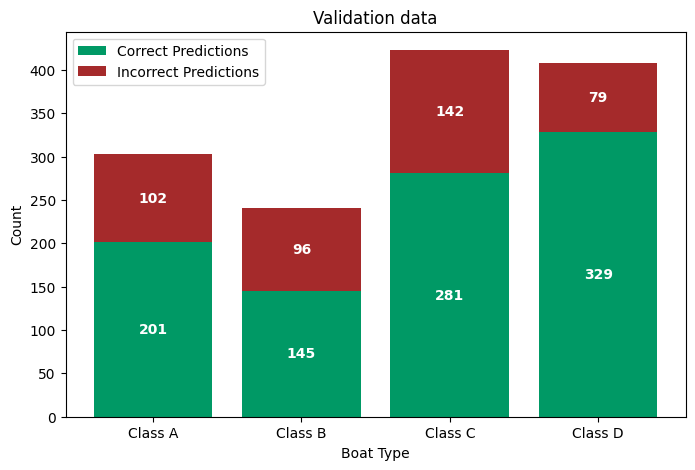

Confusion Matrix:
   Class A  Class B  Class C  Class D
0      201       29       39       34
1       23      145       64        9
2       44       63      281       35
3       34       13       32      329

Metrics:
     Class  Precision    Recall  F1 Score  Accuracy
0  Class 0   0.665563  0.663366  0.664463  0.695273
1  Class 1   0.580000  0.601660  0.590631  0.695273
2  Class 2   0.675481  0.664303  0.669845  0.695273
3  Class 3   0.808354  0.806373  0.807362  0.695273


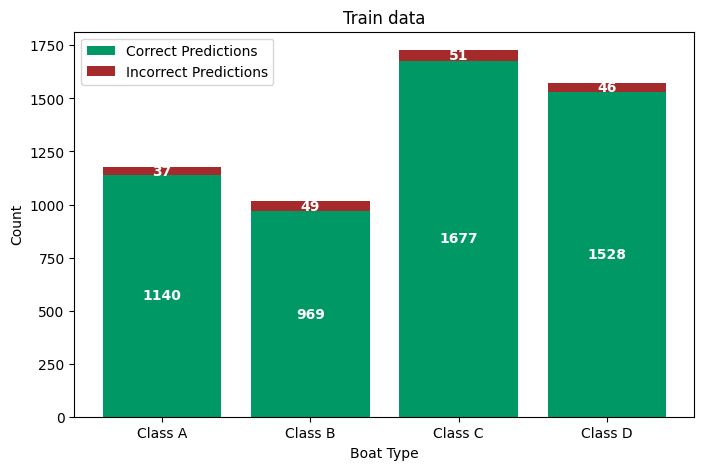

Confusion Matrix:
   Class A  Class B  Class C  Class D
0     1140       10       13       14
1       19      969       21        9
2       18       26     1677        7
3       20        8       18     1528

Metrics:
     Class  Precision    Recall  F1 Score  Accuracy
0  Class 0   0.952381  0.968564  0.960404  0.966709
1  Class 1   0.956565  0.951866  0.954210  0.966709
2  Class 2   0.969925  0.970486  0.970205  0.966709
3  Class 3   0.980745  0.970775  0.975734  0.966709


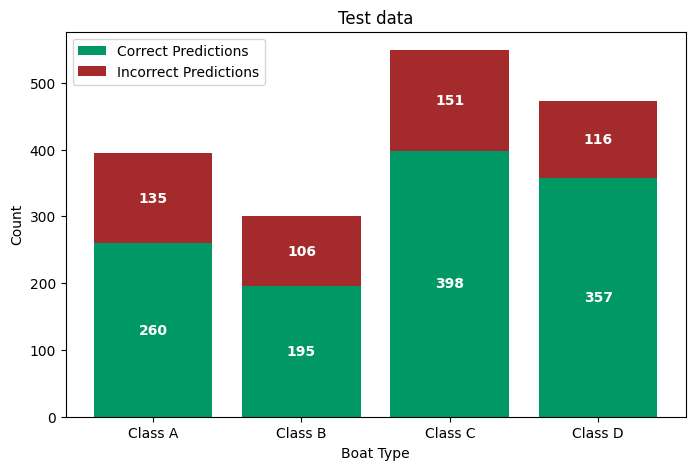

Confusion Matrix:
   Class A  Class B  Class C  Class D
0      260       23       58       54
1       31      195       60       15
2       49       58      398       44
3       42       17       57      357

Metrics:
     Class  Precision    Recall  F1 Score  Accuracy
0  Class 0   0.680628  0.658228  0.669241  0.704307
1  Class 1   0.665529  0.647841  0.656566  0.704307
2  Class 2   0.694590  0.724954  0.709447  0.704307
3  Class 3   0.759574  0.754757  0.757158  0.704307


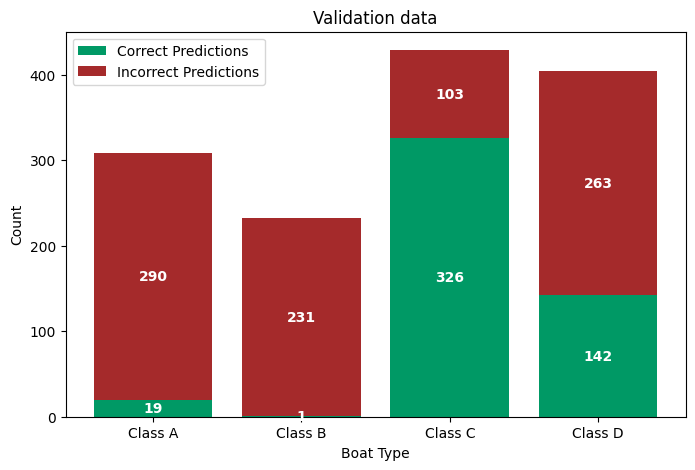

Confusion Matrix:
   Class A  Class B  Class C  Class D
0       19        2      205       83
1       15        1      176       40
2       18        0      326       85
3       35        0      228      142

Metrics:
     Class  Precision    Recall  F1 Score  Accuracy
0  Class 0   0.218391  0.061489  0.095960  0.354909
1  Class 1   0.333333  0.004310  0.008511  0.354909
2  Class 2   0.348663  0.759907  0.478006  0.354909
3  Class 3   0.405714  0.350617  0.376159  0.354909


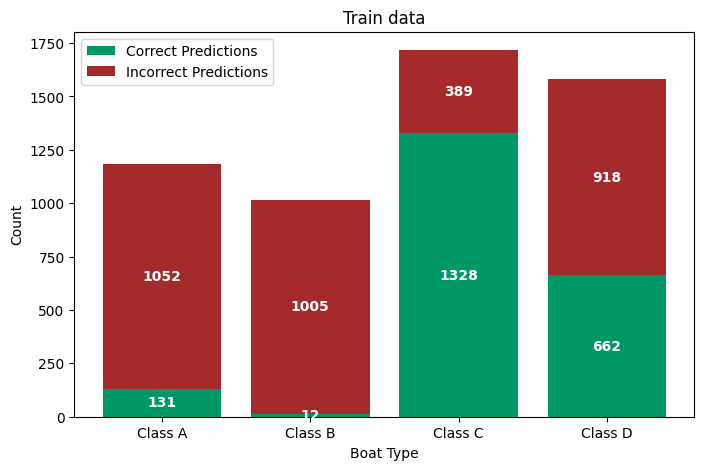

Confusion Matrix:
   Class A  Class B  Class C  Class D
0      131        2      841      209
1       21       12      844      140
2       72        6     1328      311
3      102        1      815      662

Metrics:
     Class  Precision    Recall  F1 Score  Accuracy
0  Class 0   0.401840  0.110735  0.173625   0.38803
1  Class 1   0.571429  0.011799  0.023121   0.38803
2  Class 2   0.346917  0.773442  0.478990   0.38803
3  Class 3   0.500756  0.418987  0.456237   0.38803


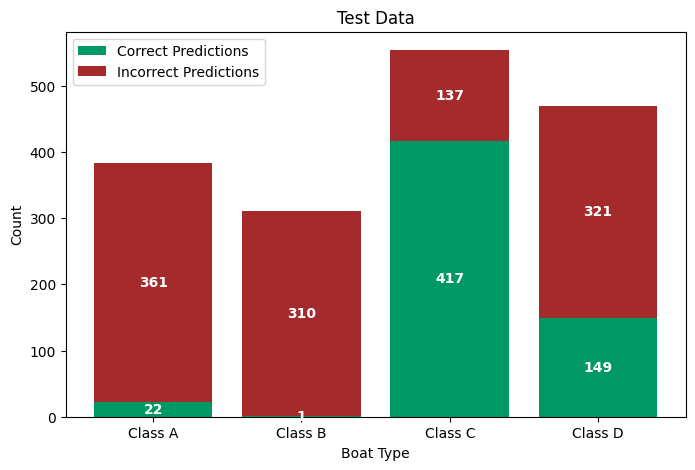

Confusion Matrix:
   Class A  Class B  Class C  Class D
0       22        3      276       82
1       14        1      244       52
2       20        4      417      113
3       34        2      285      149

Metrics:
     Class  Precision    Recall  F1 Score  Accuracy
0  Class 0   0.244444  0.057441  0.093023  0.342841
1  Class 1   0.100000  0.003215  0.006231  0.342841
2  Class 2   0.341244  0.752708  0.469595  0.342841
3  Class 3   0.376263  0.317021  0.344111  0.342841


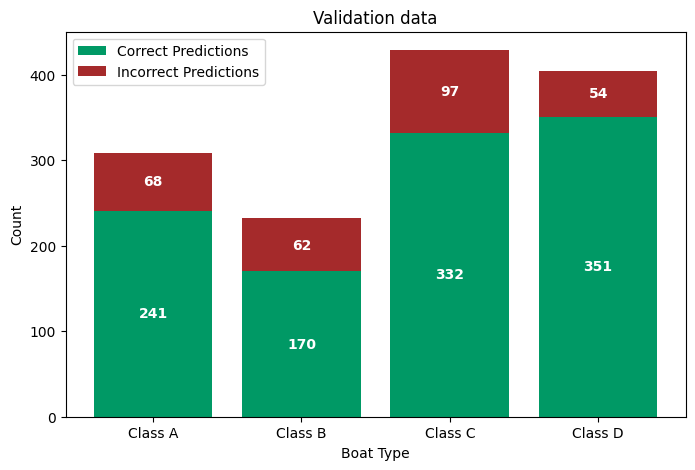

Confusion Matrix:
   Class A  Class B  Class C  Class D
0      241       17       24       27
1       20      170       37        5
2       27       53      332       17
3       19        6       29      351

Metrics:
     Class  Precision    Recall  F1 Score  Accuracy
0  Class 0   0.785016  0.779935  0.782468  0.795636
1  Class 1   0.691057  0.732759  0.711297  0.795636
2  Class 2   0.786730  0.773893  0.780259  0.795636
3  Class 3   0.877500  0.866667  0.872050  0.795636


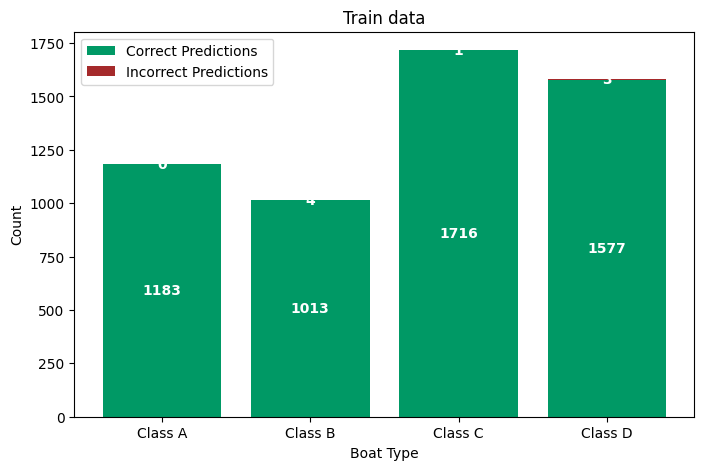

Confusion Matrix:
   Class A  Class B  Class C  Class D
0     1183        0        0        0
1        4     1013        0        0
2        1        0     1716        0
3        2        0        1     1577

Metrics:
     Class  Precision    Recall  F1 Score  Accuracy
0  Class 0   0.994118  1.000000  0.997050  0.998545
1  Class 1   1.000000  0.996067  0.998030  0.998545
2  Class 2   0.999418  0.999418  0.999418  0.998545
3  Class 3   1.000000  0.998101  0.999050  0.998545


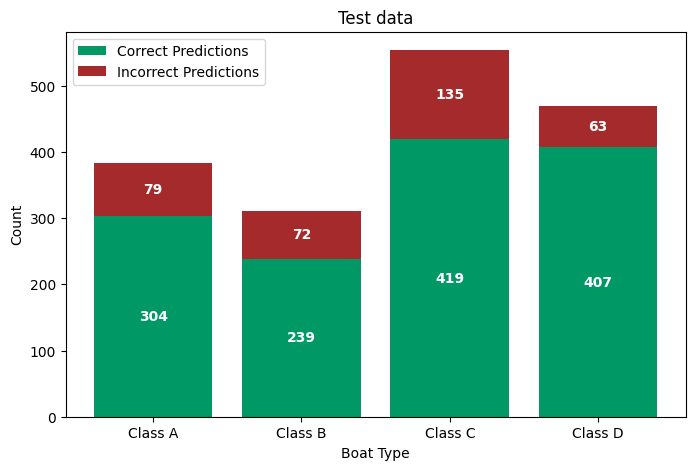

Confusion Matrix:
   Class A  Class B  Class C  Class D
0      304       27       26       26
1       22      239       46        4
2       43       67      419       25
3       26        9       28      407

Metrics:
     Class  Precision    Recall  F1 Score  Accuracy
0  Class 0   0.769620  0.793734  0.781491  0.796857
1  Class 1   0.698830  0.768489  0.732006  0.796857
2  Class 2   0.807322  0.756318  0.780988  0.796857
3  Class 3   0.880952  0.865957  0.873391  0.796857


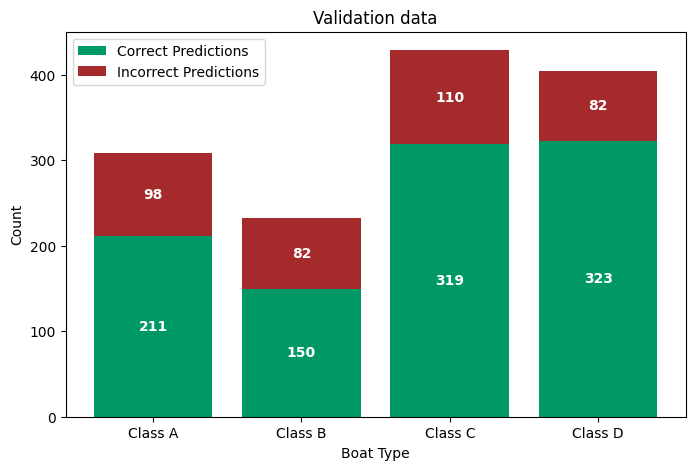

Confusion Matrix:
   Class A  Class B  Class C  Class D
0      211       27       44       27
1       25      150       35       22
2       38       43      319       29
3       30       15       37      323

Metrics:
     Class  Precision    Recall  F1 Score  Accuracy
0  Class 0   0.694079  0.682848  0.688418  0.729455
1  Class 1   0.638298  0.646552  0.642398  0.729455
2  Class 2   0.733333  0.743590  0.738426  0.729455
3  Class 3   0.805486  0.797531  0.801489  0.729455


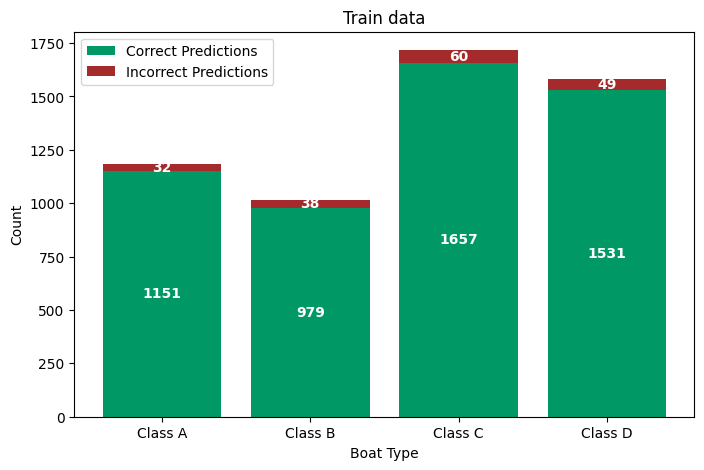

Confusion Matrix:
   Class A  Class B  Class C  Class D
0     1151       10       13        9
1       20      979       14        4
2       27       23     1657       10
3       20       15       14     1531

Metrics:
     Class  Precision    Recall  F1 Score  Accuracy
0  Class 0   0.944992  0.972950  0.958767  0.967437
1  Class 1   0.953262  0.962635  0.957926  0.967437
2  Class 2   0.975854  0.965055  0.970425  0.967437
3  Class 3   0.985199  0.968987  0.977026  0.967437


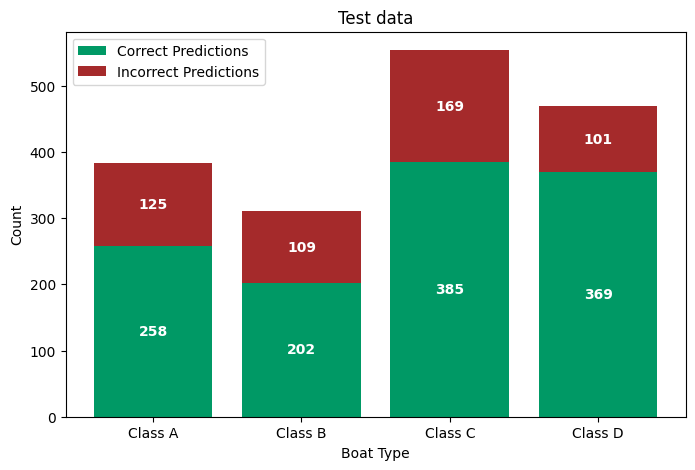

Confusion Matrix:
   Class A  Class B  Class C  Class D
0      258       31       64       30
1       38      202       54       17
2       69       61      385       39
3       38       31       32      369

Metrics:
     Class  Precision    Recall  F1 Score  Accuracy
0  Class 0   0.640199  0.673629  0.656489  0.706636
1  Class 1   0.621538  0.649518  0.635220  0.706636
2  Class 2   0.719626  0.694946  0.707071  0.706636
3  Class 3   0.810989  0.785106  0.797838  0.706636


In [ ]:
#@title 5.2 Test results extraction

# Metric activator
raw = 1
mfcc = 1
psd = 1

metrics_raw1 = []
metrics_mfcc1 = []
metrics_psd1 = []

matrix_raw = []
matrix_mfcc = []
matrix_psd = []

val = 1

data = ['data1.pkl','data2.pkl','data3.pkl','data4.pkl','data5.pkl']

for d in data:
  X_train, X_test, X_val, y_train, y_test, y_val = dataload(d)

  if raw == 1:
  # Get raw data
    metrics, matrix = get_DT_rawdata(val)
    metrics_raw1.append(metrics)
    matrix_raw.append(matrix)
  if mfcc == 1:
  # Get mfcc data
    mfcc_train, mfcc_val, mfcc_test = get_mfcc()
    metrics1, matrix1 = get_DT_mfcc(val)
    metrics_mfcc1.append(metrics1)
    matrix_mfcc.append(matrix1)
 # Get psd data
  if psd == 1:
    psd_train, psd_val, psd_test = get_psd()
    metrics2, matrix2 = get_DT_psd(val)
    metrics_psd1.append(metrics2)
    matrix_psd.append(matrix2)
  val = val + 1

pd.options.display.float_format = '{:.3f}'.format

if raw == 1:
  metrics_raw = metrics_avg_var(metrics_raw1)
if mfcc == 1:
  metrics_mfcc = metrics_avg_var(metrics_mfcc1)
if psd == 1:
  metrics_psd = metrics_avg_var(metrics_psd1)


In [ ]:
#@title Print Table

def get_number(row,col, metrics):
 cols = ['Precision','Recall','F1 Score']
 a = metrics.at[row,col]
 highest = 0
 if col in cols:
  for value in metrics[col]:
    if value > a:
      highest = 1
  if highest == 0:
    a = "\highest{" + str(a) + "}"
 return str(a)

def print_table(metrics):

#metrics table formatting


  columns_to_format = ['Precision',
                        'Recall',
                        'F1 Score',
                          'Accuracy']
  metrics[columns_to_format] = metrics[columns_to_format].round(3)
  columns_to_format = ['P_std','R_std','F1_std','Acc_std']
  metrics[columns_to_format] = metrics[columns_to_format].round(3)


  print(
  "Class A                           & " + get_number(0,'Precision',metrics) + "                               & (" + get_number(0,'P_std',metrics) + ")     & " + get_number(0,'Recall',metrics) + "                         & (" + get_number(0,'R_std',metrics) + ")         & " + get_number(0,'F1 Score',metrics) + "                  & (" + get_number(0,'F1_std',metrics) + ")                   \\\\"
  " \\rowcolor[HTML]{EFEFEF} Class B                           & " + get_number(1,'Precision',metrics) + "                               & (" + get_number(1,'P_std',metrics) + ")      & " + get_number(1,'Recall',metrics) + "                         & (" + get_number(1,'R_std',metrics) + ")         & " + get_number(1,'F1 Score',metrics) + "                  & (" + get_number(1,'F1_std',metrics) + ")                  \\\\"
  "Class C                           & " + get_number(2,'Precision',metrics) + "                               & (" + get_number(2,'P_std',metrics) + ")      & " + get_number(2,'Recall',metrics) + "                        & (" + get_number(2,'R_std',metrics) + ")         & " + get_number(2,'F1 Score',metrics) + "                  & (" + get_number(2,'F1_std',metrics) + ")                  \\\\")
  print("\\rowcolor[HTML]{EFEFEF} "
  "Class D                           & " + get_number(3,'Precision',metrics) + "                              & (" + get_number(3,'P_std',metrics) + ")      & " + get_number(3,'Recall',metrics) + "                         & (" + get_number(3,'R_std',metrics) + ")         & " + get_number(3,'F1 Score',metrics) + "                  & (" + get_number(3,'F1_std',metrics) + ")                 \\\\ \midrule"
  "\\multicolumn{1}{c}{\\textbf{Accuracy($\sigma$)}} & \multicolumn{1}{c}{\\textbf{}}       &            & \multicolumn{1}{l}{}          &               & \\textbf{" + get_number(3,'Accuracy',metrics) + "}         & \\textbf{(" + get_number(2,'Acc_std',metrics) + ")}  ")
  return


print_table(metrics_psd)

Class A                           & 0.676                               & (0.024)     & 0.682                         & (0.027)         & 0.679                  & (0.02)                   \\ \rowcolor[HTML]{EFEFEF} Class B                           & 0.634                               & (0.025)      & 0.634                         & (0.019)         & 0.634                  & (0.021)                  \\Class C                           & 0.707                               & (0.013)      & 0.706                        & (0.015)         & 0.706                  & (0.002)                  \\
\rowcolor[HTML]{EFEFEF} Class D                           & \highest{0.797}                              & (0.021)      & \highest{0.791}                         & (0.023)         & \highest{0.794}                  & (0.019)                 \\ \midrule\multicolumn{1}{c}{\textbf{Accuracy($\sigma$)}} & \multicolumn{1}{c}{\textbf{}}       &            & \multicolumn{1}{l}{}          &               & \t

In [ ]:
#@title Print Matrix

def get_max_matrix(matrix):
  a = 0
  pos = 5
  tp_max = 0
  for m in matrix:
    tp = sum(np.diagonal(m))
    if tp_max < tp:
      tp_max = tp
      pos = a
    a = a+1
  return pos

def get_matrix(matrix):
  matrix = matrix[get_max_matrix(matrix)]
  col = ['Class A','Class B','Class C','Class D']
  for i in list(range(4)):
    for j in list(range(4)):
      print(j,i,matrix.at[i,col[j]])

print("x y C")
get_matrix(matrix_mfcc)


x y C
0 0 304
1 0 27
2 0 26
3 0 26
0 1 22
1 1 239
2 1 46
3 1 4
0 2 43
1 2 67
2 2 419
3 2 25
0 3 26
1 3 9
2 3 28
3 3 407


In [ ]:
#@title 5. Represent Decission Tree

from subprocess import call
from sklearn.tree import export_graphviz
import graphviz

# Generate the decission tree
dot_data = export_graphviz(tree_mfcc, out_file=None,
                           filled=True, rounded=True,
                           special_characters=True)

# Render the decision tree using Graphviz
graph = graphviz.Source(dot_data)
graph_pdf_bytes = graph.pipe(format='pdf')

# Save the PDF to a file
with open('decision_tree.pdf', 'wb') as f:
    f.write(graph_pdf_bytes)

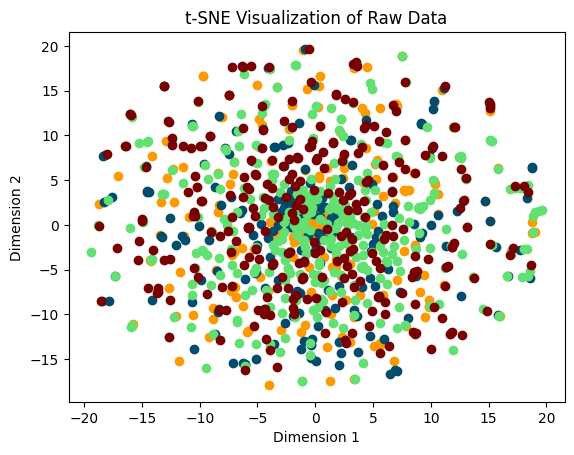

In [ ]:
from sklearn.manifold import TSNE

#@title Raw data t-SNE Visualization

tsne = TSNE(n_components=2,perplexity = 15, random_state=42)
data_2d = tsne.fit_transform(np.array(X_train[0:1000]))
plt.scatter(data_2d[y_train[0:1000]==0, 0], data_2d[y_train[0:1000]==0, 1], label='Class A', color='#FF9900')
plt.scatter(data_2d[y_train[0:1000]==1, 0], data_2d[y_train[0:1000]==1, 1], label='Class B', color='#004C6D')
plt.scatter(data_2d[y_train[0:1000]==2, 0], data_2d[y_train[0:1000]==2, 1], label='Class C', color='#63E072')
plt.scatter(data_2d[y_train[0:1000]==3, 0], data_2d[y_train[0:1000]==3, 1], label='Class D', color='#790000')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.title('t-SNE Visualization of Raw Data')

plt.show()